In [176]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import imutils
from scipy.spatial.distance import cdist
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float
import matplotlib.patches as patches
from copy import deepcopy
from itertools import combinations
%matplotlib inline

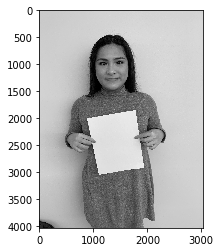

In [551]:
filename = '../images/julia2.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')
plt.show()

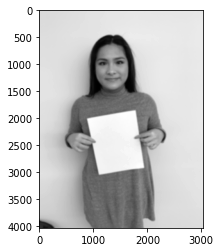

In [552]:
r = 75
img_gaussian = cv2.GaussianBlur(gray,(r,r),0)
plt.imshow(img_gaussian, cmap = 'gray')
plt.show()

In [553]:
r_img = imutils.resize(img, width=int(0.1*np.shape(img)[1]))

In [554]:
from skimage.filters import roberts

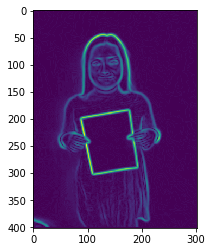

In [555]:
r = 9
r_img = imutils.resize(img, width=int(0.1*np.shape(img)[1]))
filt_img = cv2.GaussianBlur(r_img[:,:,0],(r,r),0)
img_roberts = roberts(filt_img)
plt.imshow(img_roberts)
img_roberts = cv2.normalize(src=img_roberts, dst=None, alpha=0, beta=255, 
               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

In [556]:
#img_roberts.convertTo(img_roberts, CV_8UC1, 1/256.0)
cnts = cv2.findContours(img_roberts, mode = 3, method = 1)
cnts = cv2.findContours(img_roberts, cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

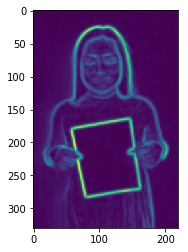

In [591]:
c_top, c_bottom = 20, 350
c_left, c_right = 30, 250
crop = img_roberts[c_top:c_bottom, c_left:c_right]
#crop = img_roberts[:,:]
bi = cv2.bilateralFilter(crop, 5, 75, 75)
plt.imshow(bi)

In [592]:
dst = cv2.cornerHarris(bi, 2, 3, 0.04)

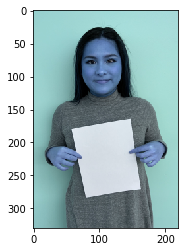

In [593]:
r_img_crop = r_img[c_top:c_bottom, c_left:c_right]
#r_img_crop = r_img[:,:]
mask = np.zeros_like(r_img_crop)

corners = dst > 0.1*dst.max()
plt.imshow(r_img_crop)

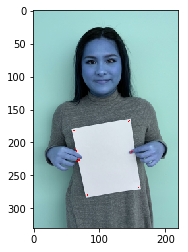

In [594]:
r_img_copy = deepcopy(r_img[c_top:c_bottom, c_left:c_right,:])
#r_img_copy = deepcopy(r_img[:,:,:])
r_img_copy[corners] = [255,0,0]
plt.imshow(r_img_copy)

In [595]:
corners_loc = np.where(corners)
xy_corners = list(zip(corners_loc[1], corners_loc[0]))

In [596]:
#Fuse points that are too close to each other
def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d):
    ret = []
    d2 = d * d
    n = len(points)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            count = 1
            point = [points[i][0], points[i][1]]
            taken[i] = True
            for j in range(i+1, n):
                if dist2(points[i], points[j]) < d2:
                    point[0] += points[j][0]
                    point[1] += points[j][1]
                    count+=1
                    taken[j] = True
            point[0] /= count
            point[1] /= count
            ret.append((point[0], point[1]))
    return ret

fused_corners = fuse(xy_corners, 5)
print('Before Fusing:',len(xy_corners), 'After Fusing:',len(fused_corners))
xs = [p[0] for p in fused_corners]
ys = [p[1] for p in fused_corners]
print(xs)
print(ys)

Before Fusing: 47 After Fusing: 11
[145.0, 61.0, 60.5, 153.0, 65.28571428571429, 149.0, 69.28571428571429, 67.44444444444444, 70.0, 159.66666666666666, 82.25]
[167.5, 181.5, 209.0, 208.0, 212.28571428571428, 214.5, 223.71428571428572, 227.55555555555554, 227.75, 268.3333333333333, 279.75]


In [597]:
index = list(range(0, len(fused_corners)))
index_combinations = list(combinations(index, 4))
print(len(index),len(index_combinations))

11 330


In [598]:
def getXYforIndices(all_x, all_y, indices):
    x = []
    y = []
    for index in indices:
        x.append(all_x[index])
        y.append(all_y[index])
    return x, y

In [599]:
xy_combinations = []
for comb in index_combinations:
    #xy_combinations.append(getXYforIndices(corners_loc[1], corners_loc[0], comb))
    xy_combinations.append(getXYforIndices(xs, ys, comb))
len(xy_combinations)

330

In [600]:
to_remove = []
for xy_comb in xy_combinations:
    xy_distances = cdist(list(zip(xy_comb[0], xy_comb[1])), 
          list(zip(xy_comb[0], xy_comb[1])))
    not_rectangular = np.where((xy_distances > 0) & (xy_distances <= 5))
    
    if len(not_rectangular[0]) or len(not_rectangular[1]): 
        to_remove.append(xy_comb)
        
for r in to_remove:
    xy_combinations.remove(r)

In [601]:
# x = np.array([118, 182, 117, 177])
# y = np.array([166, 170, 247, 251])

def getClockwiseOrder(x, y):
    max2x = np.argpartition(x, -2)[-2:]
    max2y = np.argpartition(y, -2)[-2:]
    min2x = np.argpartition(x, 2)[:2]
    min2y = np.argpartition(y, 2)[:2]
    tl = np.intersect1d(min2x, min2y)
    tr = np.intersect1d(max2x, min2y)
    br = np.intersect1d(max2x, max2y)
    bl = np.intersect1d(min2x, max2y)
    if len(tl) and len(tr) and len(br) and len(bl):
        return x[np.concatenate((tl,tr,br,bl))], y[np.concatenate((tl,tr,br,bl))]
    else:
        return None, None

In [602]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [603]:
largest_area = 0
best_rectangle = ([],[])
for xy_comb in xy_combinations:
    x = np.array(xy_comb[0])
    y = np.array(xy_comb[1])
    x, y = getClockwiseOrder(x, y)
    if x is None or y is None:
        continue
    area = PolyArea(x, y)
    if area > largest_area:
        largest_area = area
        print(area)
        best_rectangle = (x, y)

3028.625
3220.25
5716.041666666664
5994.9375
6060.499999999993
6329.944444444438
8262.0625


In [604]:
best_rectangle

(array([ 61.        , 145.        , 159.66666667,  82.25      ]),
 array([181.5       , 167.5       , 268.33333333, 279.75      ]))

8262.0625


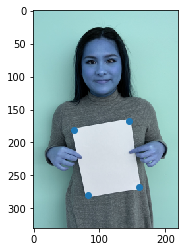

In [605]:
fig, ax = plt.subplots(1)
print(PolyArea(best_rectangle[0], best_rectangle[1]))
ax.imshow(r_img_crop)
plt.scatter(best_rectangle[0], best_rectangle[1])
plt.show()